In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

# 1- Information about the challenge

In this challenge, the `requests` dataset contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `train_requests`, the predictions should be made for requests listed in the `test_requests` dataset.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

Good luck!

# 2- Load the datasets

In [3]:
# Train sample
requests_train = pd.read_csv('data/train_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

# Test sample
requests_test = pd.read_csv('data/test_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


In [4]:
# Inspect basic metadata about the dataset
print(requests_train.info())
print(requests_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297739 entries, 0 to 297738
Data columns (total 24 columns):
request_id                       297739 non-null object
animal_presence                  297739 non-null object
answer_creation_date             297739 non-null object
child_situation                  297739 non-null int64
child_to_come                    115453 non-null object
district                         297739 non-null int64
granted_number_of_nights         297739 non-null int64
group_composition_id             297739 non-null int64
group_composition_label          297738 non-null object
group_creation_date              297738 non-null object
group_id                         297739 non-null object
group_main_requester_id          297739 non-null object
group_type                       297738 non-null object
housing_situation_id             297739 non-null int64
housing_situation_label          276802 non-null object
long_term_housing_request        90926 non-null object

# 3- Distribution of the target

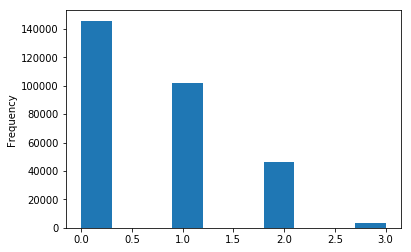

In [5]:
# histogram of the target variable
requests_train['granted_number_of_nights'].plot.hist()
None
#print(requests.head())

# 4-Train and evaluate a first model

In [6]:
# selected columns for explanatory variable
columns = ['animal_presence', 'answer_creation_date', 'child_situation',
           'child_to_come', 'district',
           'group_composition_label', 'group_creation_date',
           'group_type','housing_situation_id',
           'long_term_housing_request', 'number_of_underage',
           'request_creation_date',
           'requester_type', 'town',
           'victim_of_violence', 'victim_of_violence_type']

X = requests_train[columns]
y = requests_train['granted_number_of_nights']
X_length = len(X)
X_test = requests_test[columns]

all_dataset = pd.concat([X, X_test], sort=False)
#print(all_dataset.iloc[:X_length].tail())

In [7]:
def pre_process(X):
    X = X.fillna('12123')
    return X

In [8]:
oenc = OrdinalEncoder()
#oenc = OneHotEncoder(sparse=True)
benc = OneHotEncoder(sparse=False)

category_col = ['district', 'group_type', 'housing_situation_id', 'long_term_housing_request',
         'requester_type', 'town']
bool_cols = ['animal_presence', 'child_to_come', 'animal_presence', 'group_composition_label', 'victim_of_violence', 'victim_of_violence_type']
other_cols = ['child_situation', 'number_of_underage']

all_dataset = pre_process(all_dataset)
cat = all_dataset[category_col]
boo = all_dataset[bool_cols]
other = all_dataset[other_cols]

oenc.fit(cat)
benc.fit(boo)
print(oenc.transform(cat).shape)
cat = oenc.transform(cat)

print(benc.transform(boo).shape)
boo = benc.transform(boo)
other = other.values

print(cat.shape)
print(boo.shape)
print(other.shape)
data = np.concatenate((boo, cat, other), axis=1)
all_dataset = data

(371928, 6)
(371928, 30)
(371928, 6)
(371928, 30)
(371928, 2)


In [9]:
print(all_dataset[:X_length].shape)
#print(y)

(297739, 38)


In [10]:
data

array([[ 1.,  0.,  1., ...,  0., -1., -1.],
       [ 1.,  0.,  1., ...,  0., -1., -1.],
       [ 1.,  0.,  1., ...,  0., -1., -1.],
       ...,
       [ 1.,  0.,  1., ...,  0., -1., -1.],
       [ 1.,  0.,  1., ...,  0., -1., -1.],
       [ 1.,  0.,  0., ...,  0., -1.,  1.]])

In [11]:
# split between the train and the validation samples
X = all_dataset[:X_length]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [27]:
model = RandomForestClassifier(n_estimators=10, min_samples_split=15, max_depth=10, max_features=20, class_weight={0: 1, 1: 10, 2: 100, 3: 1000}, random_state=42)
#model = LogisticRegression(C=1.0, solver='newton-cg', penalty='none', multi_class='multinomial',max_iter=200, class_weight={0: 1, 1: 10, 2: 100, 3: 1000}, verbose=10)
print(model)
#model = DecisionTreeClassifier(class_weight={0: 1, 1: 10, 2: 100, 3: 1000})

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 1, 1: 10, 2: 100, 3: 1000},
                       criterion='gini', max_depth=10, max_features=20,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)


In [30]:
# fit the model
#model.fit(X_train, y_train)
model.fit(X, y)

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 1, 1: 10, 2: 100, 3: 1000},
                       criterion='gini', max_depth=10, max_features=20,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [31]:
# evaluate the model with the competition scorer (validation set)
print(competition_scorer(y_val, model.predict_proba(X_val)))

0.6292249905187488


In [32]:
model.classes_

array([0, 1, 2, 3])

# 5- Compute predictions on the test set 

In [33]:
# use the model to predict on the test set
X_test = all_dataset[X_length:]
y_pred = model.predict_proba(X_test)

In [34]:
# overview of prediction probabilities for first four rows
y_pred[:4]

array([[0.00565893, 0.19956362, 0.53062778, 0.26414967],
       [0.04831256, 0.15340572, 0.62797262, 0.17030909],
       [0.00386934, 0.13440999, 0.69957158, 0.16214909],
       [0.05251389, 0.05843035, 0.33935932, 0.54969644]])

In [35]:
predictions = pd.concat([requests_test['request_id'], pd.DataFrame(y_pred)], axis=1)

# 6- Submit your predictions to the QScore platform

In [36]:
import io, math, requests

# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='ddb80cdfd01cc72a553168352c66b2232c943d0e6c91241187cc0e007fe29777a4c8af8d0c1e3689e768ca0029d7e055afeb4ff55f9d8cd5128729cc9829cc5d'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [38]:
submit_prediction(predictions, sep=',', index=False, comment='my submission')